In [5]:
isMac = False

In [6]:
# for plotting, run: pip install pandas matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import medfilt, sosfilt, ellip, iirnotch, freqz, filtfilt
from sklearn.preprocessing import MinMaxScaler

import wfdb
!pip install -q gluonts

from gluonts.dataset.pandas import PandasDataset

In [7]:
if isMac:
    from chronos_mlx import ChronosPipeline
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    dtype="bfloat16",
    )
else:
    import torch
    from chronos import ChronosPipeline
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
    )

In [9]:
data_dir = '../data/mitdb'

np.random.seed(0)
random_file_choice = ['/'+x for x in np.random.choice(os.listdir(data_dir), min(len(os.listdir(data_dir)), 10), replace=False)]
random_file_choice

['/data-source.txt']

In [10]:
filename_list = list(set([x[:-4] for x in random_file_choice if x[:-4] + '.dat' in random_file_choice]))
filename_list

[]

In [11]:
for filename_base in filename_list:
    file_path = data_dir + filename_base

    record = wfdb.rdrecord(file_path)

    # plot the record to screen
    wfdb.plot_wfdb(record=record, title=f'{filename_base[1:]}')

In [12]:
# Raw Data Representation

MLII = record.to_dataframe()[['MLII']]
display(MLII)
plt.plot(MLII)

NameError: name 'record' is not defined

In [13]:

MLII_quantiles = np.quantile(MLII, [0.00005,0.99995])
MLII[((MLII>MLII_quantiles[0]) | (MLII<MLII_quantiles[1]))]

MLII = MLII[((MLII>MLII_quantiles[0]) & (MLII<MLII_quantiles[1]))].ffill()
plt.plot(MLII)

NameError: name 'MLII' is not defined

In [14]:
# With Simple Moving Average (3 frame window)

MLII_SMA = MLII.rolling(3).mean()
plt.plot(MLII_SMA)

NameError: name 'MLII' is not defined

In [15]:
# With median filtering

MLII_medfilt = medfilt((MLII_SMA).values.flatten(),3)
MLII_medfilt = pd.Series(MLII_medfilt).bfill()
plt.plot(MLII_medfilt)

NameError: name 'MLII_SMA' is not defined

In [16]:
# With second-order section filter

sos = ellip(N = 2, rp = 0.09, rs = 80, Wn = 0.09, output='sos')
MLII_sos = sosfilt(sos, MLII_medfilt)
plt.plot(MLII_sos)

NameError: name 'MLII_medfilt' is not defined

In [17]:
# Remove 60Hz analog-digital conversion tone from signal

fs = 360.0  # Sample frequency (Hz)

f0 = 60.0  # Frequency to be removed from signal (Hz)

Q = 30.0  # Quality factor

# Design notch filter

b_notch, a_notch = iirnotch(f0, Q, fs)

MLII_notch = filtfilt(b_notch, a_notch, MLII_sos)
plt.plot(MLII_notch)

NameError: name 'MLII_sos' is not defined

In [18]:
# Normalize for (0,1)

scaler = MinMaxScaler()

MLII_minmax = scaler.fit_transform(MLII_notch.reshape((-1,1))).flatten()
plt.plot(MLII_minmax)

NameError: name 'MLII_notch' is not defined

In [19]:
#Show difference from original and processed signal

plt.plot(MLII.values[:1000], label = 'original', alpha = 0.7, linewidth = 5)
plt.plot(MLII_notch[:1000], label ='ALL', alpha = 0.5)
plt.legend()
plt.show()


NameError: name 'MLII' is not defined

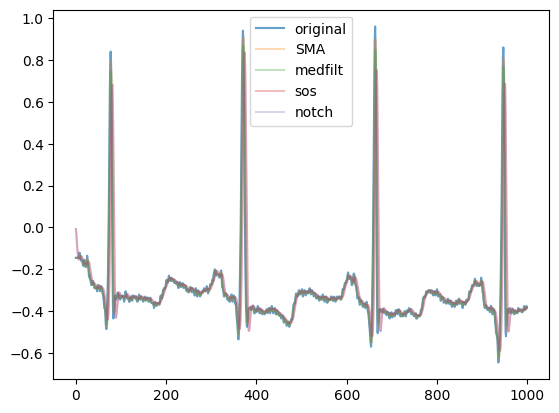

In [13]:
# All signals plotted

plt.plot(MLII.values[:1000], label = 'original', alpha = 0.7)
plt.plot(MLII_SMA.values[:1000], label = 'SMA', alpha = 0.3)
plt.plot(MLII_medfilt[:1000], label = 'medfilt', alpha = 0.3)
plt.plot(MLII_sos[:1000], label = 'sos', alpha = 0.3)
plt.plot(MLII_notch[:1000], label = 'notch', alpha = 0.3)
plt.legend()

In [ ]:
####  The following Code is not likely to work without further development.  
####  Left here as a starting place for passing processed data.

In [ ]:
df_wide = pd.read_csv(data_dir + random_file_choice[0], names = ['Lead-'+ str(f) for f in range(1,13)])

plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, feature_name in enumerate(df_wide.columns):
    ax = plt.subplot(3, 4, idx+1)
    df_feat = df_wide[feature_name].reset_index()
    prediction_length = 50
    context_length = 200
    context_start_position = len(df_feat) - prediction_length - context_length
    context = df_feat[feature_name].values[context_start_position:context_start_position+context_length]
    true_ts = df_feat[feature_name].values[context_start_position:]
    forecast = pipeline.predict(
        context,
        prediction_length,
        num_samples=20,
        temperature=1.0,
        top_k=100,
        top_p=1,
    ) # forecast shape: [num_series, num_samples, prediction_length]

    # visualize the forecast
    ts_index = range(len(df_feat)-prediction_length*4, len(df_feat))
    forecast_index = range(context_start_position+context_length, len(df_feat))
    low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

    # plt.figure(figsize=(8, 4))
    ax.plot(ts_index, df_feat[feature_name].values[-prediction_length*4:], color="royalblue", label="historical data")
    ax.plot(forecast_index, median, color="tomato", label="median forecast")
    ax.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
    ax.set_title(feature_name)    

    ax.grid()

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 2))
plt.suptitle('Chronos - ECG Leads (Denoised)', y=1.03, fontsize = 30)
plt.show()


In [ ]:
df_wide = pd.read_csv(data_dir + standard_ecg_dir + random_file_choice[0], header=0, names = ['Lead-'+ str(f) for f in range(1,13)])

plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, feature_name in enumerate(df_wide.columns):
    ax = plt.subplot(3, 4, idx+1)
    df_feat = df_wide[feature_name].reset_index()
    prediction_length = 50
    context_length = 200
    context_start_position = len(df_feat) - prediction_length - context_length
    context = df_feat[feature_name].values[context_start_position:context_start_position+context_length]
    true_ts = df_feat[feature_name].values[context_start_position:]
    forecast = pipeline.predict(
        context,
        prediction_length,
        num_samples=100,
        temperature=1,
        top_k=100,
        top_p=1.0,
    ) # forecast shape: [num_series, num_samples, prediction_length]

    # visualize the forecast
    ts_index = range(len(df_feat)-prediction_length*4, len(df_feat))
    forecast_index = range(context_start_position+context_length, len(df_feat))
    low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

    # plt.figure(figsize=(8, 4))
    ax.plot(ts_index, df_feat[feature_name].values[-prediction_length*4:], color="royalblue", label="historical data")
    ax.plot(forecast_index, median, color="tomato", label="median forecast")
    ax.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
    ax.set_title(feature_name)    

    ax.grid()

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 2))
plt.suptitle('Chronos - ECG Leads (Noisy)', y=1.03, fontsize = 30)
plt.show()